<a href="https://colab.research.google.com/github/TarekAzzouni/Baterries-ML-Lithium-Ions-01/blob/main/Data_Driven_model_for_HNEI_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of the dataset : 

A batch of fifty-one 18650-format lithium ion cells was purchased from a commercial vendor. These cells were manufactured by LG Chemical Limited, (Seoul, Korea), under the model denomination “ICR18650 C2” and intended for notebook PC applications. The negative electrode (NE) was made of a graphitic intercalation compound (GIC), while the positive electrode (PE) was a blend of LiCoO2 (LCO) and LiNi4Co4Mn2O2 (NMC). The electrolyte composition was not disclosed. The recommended charge cut-off voltage was 4.30 V (associated with a 50 mA cut-off current). The recommended charge rate was C/2 and the maximum charge rate was 1 C. The recommended discharge cut-off voltage was 3.00 V and the maximum discharge rate was 2 C at ambient temperatures (5 to 45 °C). The nominal capacity was 2800 mAh and the maximum weight was 50 grams. The calculated energy density was approximately 208 Wh/kg classifying it as a high-energy cell by current standards.

# Packages 

In [158]:
import numpy as np 
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats

import tensorflow as tf
import matplotlib.pyplot as plt

import io
import requests


# Reading Data & Data leaning / processing 


In [159]:
url="https://www.batteryarchive.org/data/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a_timeseries.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [160]:
df.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.0,0.001,0.0,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.0,0.004,0.0,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.0,0.006,0.0,0.025,NaN,NaN


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651031 entries, 0 to 651030
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Date_Time                    651031 non-null  object 
 1   Test_Time (s)                651031 non-null  float64
 2   Cycle_Index                  651031 non-null  float64
 3   Current (A)                  651031 non-null  float64
 4   Voltage (V)                  651031 non-null  float64
 5   Charge_Capacity (Ah)         651031 non-null  float64
 6   Discharge_Capacity (Ah)      651031 non-null  float64
 7   Charge_Energy (Wh)           651031 non-null  float64
 8   Discharge_Energy (Wh)        651031 non-null  float64
 9   Environment_Temperature (C)  0 non-null       float64
 10  Cell_Temperature (C)         0 non-null       float64
dtypes: float64(10), object(1)
memory usage: 54.6+ MB


In [162]:
new_df = df[df['Cycle_Index'] < 2 ]

In [163]:
new_df

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.000,0.001,0.00,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.000,0.004,0.00,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.000,0.006,0.00,0.025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1951,2013-05-22 15:49:05,14558.462,1.0,0.000,4.342,2.869,0.000,11.58,0.000,NaN,NaN
1952,2013-05-22 15:49:35,14588.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1953,2013-05-22 15:50:05,14618.462,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1954,2013-05-22 15:50:34,14648.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN


In [164]:
Train = new_df.drop(new_df.index[[0, 1]])

In [165]:
Train.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.0,0.001,0.0,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.0,0.004,0.0,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.0,0.006,0.0,0.025,NaN,NaN
5,2013-05-22 11:47:55,88.319,1.0,-1.398,3.656,0.0,0.009,0.0,0.035,NaN,NaN
6,2013-05-22 11:48:01,95.294,1.0,-1.399,3.654,0.0,0.012,0.0,0.045,NaN,NaN


In [166]:
Test = df[df['Cycle_Index'] == 2 ]

In [167]:
Test.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
1956,2013-05-22 15:50:42,14655.743,2.0,-1.399,4.246,0.0,0.000,0.0,0.000,NaN,NaN
1957,2013-05-22 15:50:49,14662.750,2.0,-1.398,4.239,0.0,0.002,0.0,0.011,NaN,NaN
1958,2013-05-22 15:50:56,14669.758,2.0,-1.398,4.233,0.0,0.005,0.0,0.023,NaN,NaN
1959,2013-05-22 15:51:03,14676.735,2.0,-1.398,4.229,0.0,0.008,0.0,0.034,NaN,NaN
1960,2013-05-22 15:51:10,14683.743,2.0,-1.399,4.225,0.0,0.010,0.0,0.046,NaN,NaN


## Idea of using the tangent ( slote ) as a SoC and define as a target column

In [168]:
col_x = ['Charge_Capacity (Ah)']
col_y = ['Voltage (V)']

In [169]:
Col_X = Train[col_x]
Col_Y = Train[col_y]

In [170]:
X = Col_X.to_numpy()
Y = Col_Y.to_numpy()

In this part we are going to delete every NaN values. So, we won't have any problem. 

In [171]:
Train_1 = Train.drop(['Environment_Temperature (C)','Cell_Temperature (C)','Date_Time'],axis=1)

# Feature selection can be done in multiple ways but there are broadly 2 categories of it:



1.   Correlation Coefficient ( filter Method )
2.   Wrapper Methods (if we can get the tangent and set it as target we can you this operation )


## 1/ Correlation Coefficient 
description : Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. Furthermore, variables should be correlated with the target but should be uncorrelated among themselves.

We need to set an absolute value, say 0.5 as the threshold for selecting the variables. If we find that the predictor variables are correlated among themselves, we can drop the variable which has a lower correlation coefficient value with the target variable. We can also compute multiple correlation coefficients to check whether more than two variables are correlated to each other. This phenomenon is known as multicollinearity.

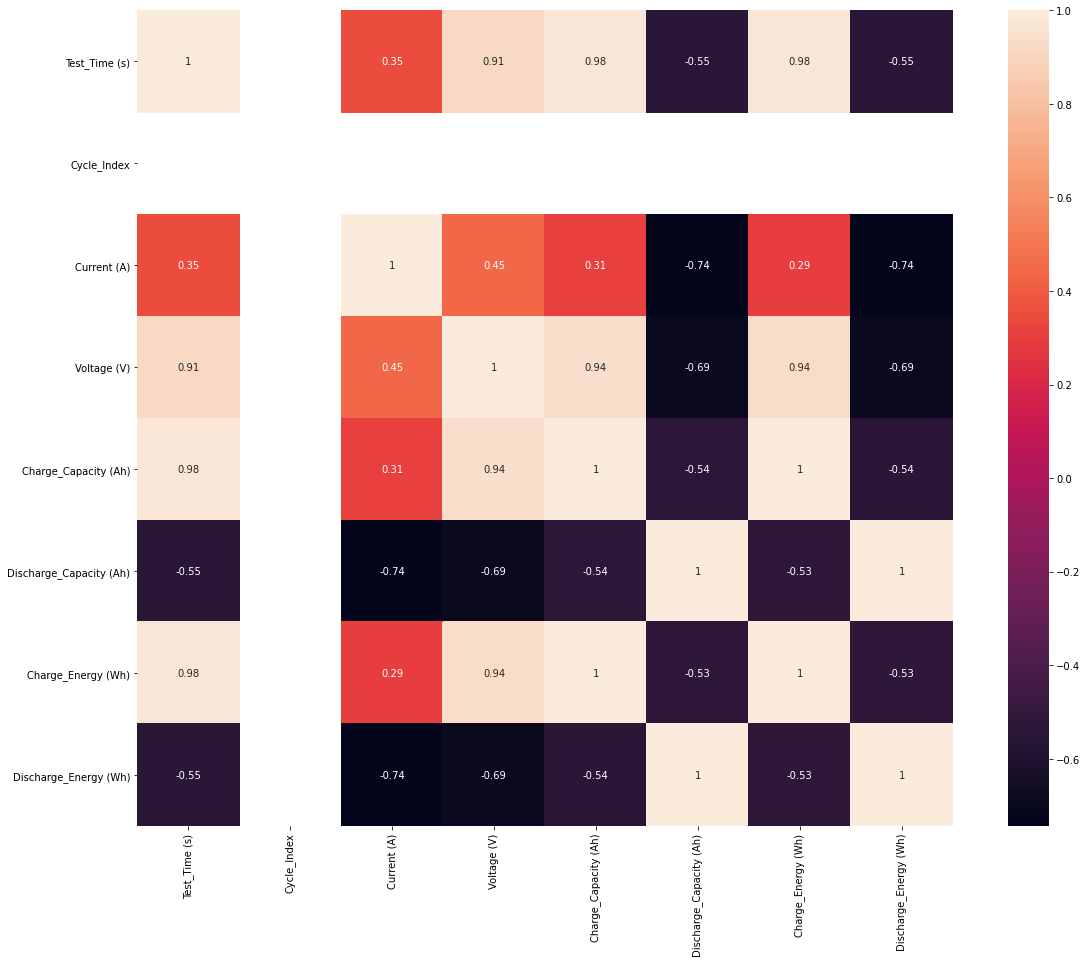

In [172]:
plt.subplots(figsize=(20,15))
cor = Train_1.corr()
sns.heatmap(cor, annot = True,square=True)

In [173]:
Train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 2 to 1955
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Test_Time (s)            1954 non-null   float64
 1   Cycle_Index              1954 non-null   float64
 2   Current (A)              1954 non-null   float64
 3   Voltage (V)              1954 non-null   float64
 4   Charge_Capacity (Ah)     1954 non-null   float64
 5   Discharge_Capacity (Ah)  1954 non-null   float64
 6   Charge_Energy (Wh)       1954 non-null   float64
 7   Discharge_Energy (Wh)    1954 non-null   float64
dtypes: float64(8)
memory usage: 137.4 KB


In [174]:

#Correlation with output variable
cor_target = abs(cor["Charge_Capacity (Ah)"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Test_Time (s)              0.978678
Voltage (V)                0.940138
Charge_Capacity (Ah)       1.000000
Discharge_Capacity (Ah)    0.537384
Charge_Energy (Wh)         0.999798
Discharge_Energy (Wh)      0.539681
Name: Charge_Capacity (Ah), dtype: float64

Interpretation of the correlation heatmap : 
As we set the charge capacity as a correlation target and we say what are the features that influence the Charge Capacity: 
those features are : 


*   Test time  & The Voltage (V) have a high correlation of 0.978678 and 0,940138 respectively we can see that they increase at the same time (verification in Data visualization part ) 
*   Charge_Energy (Wh) has a highest correlation. 
     

*   Discharge Energy (Wh) and Discharge Capacity (Ah) have a negative correlation ( see the heat map and in the data visualization part) which means that : one variable increases as the other decreases, and vice versa . 





## 2/ Wrapper Methods
Description : Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

*Forward Feature Selection :* This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved

link 1: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html?highlight=sequentialfeatureselector#sklearn.feature_selection.SequentialFeatureSelector

link 2 : https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

# Data visualization over the charge capacity 

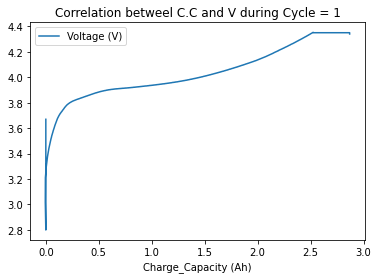

In [175]:
ax = plt.gca()

Train.plot(kind='line',x='Charge_Capacity (Ah)',y='Voltage (V)',ax=ax)
plt.title("Correlation betweel C.C and V during Cycle = 1")

plt.show()

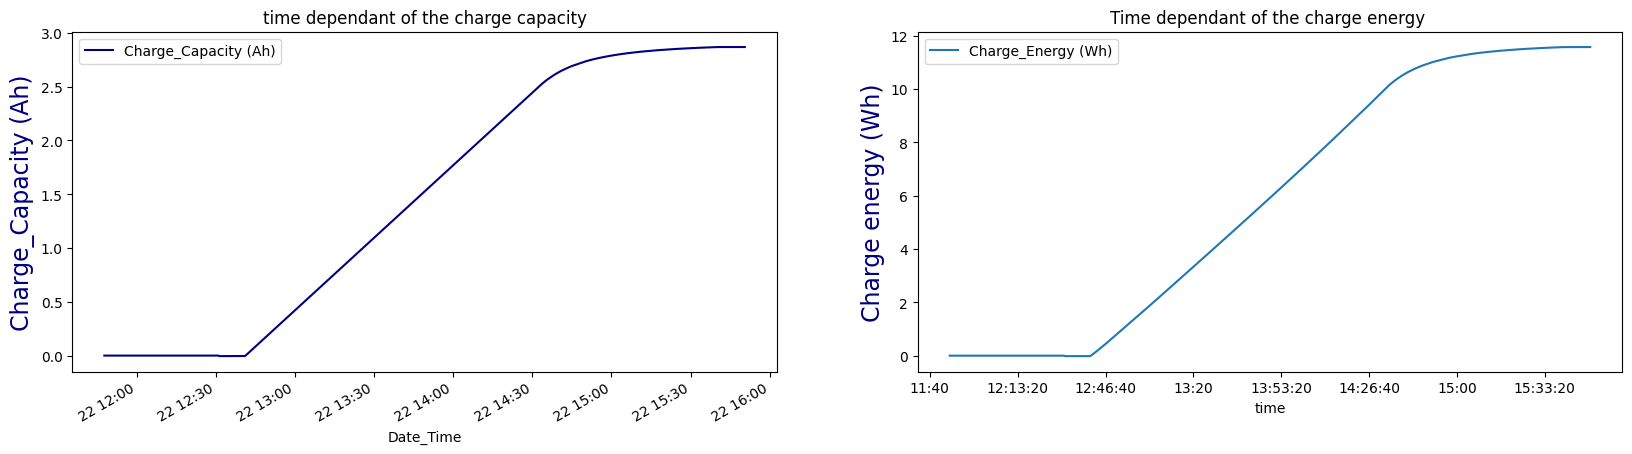

In [176]:
import datetime as dt

Train['Date_Time']= pd.to_datetime(Train['Date_Time'],format='%Y-%m-%d %H:%M')

df_gen=Train.groupby('Date_Time').sum().reset_index()
df_gen['time']=df_gen['Date_Time'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# Charge capacity plot
df_gen.plot(x='Date_Time',y='Charge_Capacity (Ah)',color='navy',ax=ax[0])
# Charge energy plot
df_gen.set_index('time').drop('Date_Time',1)[['Charge_Energy (Wh)']].plot(ax=ax[1])

ax[0].set_title('time dependant of the charge capacity',)
ax[1].set_title('Time dependant of the charge energy ')
ax[0].set_ylabel('Charge_Capacity (Ah)',color='navy',fontsize=17)
ax[1].set_ylabel('Charge energy (Wh)', color = 'navy',fontsize=17)
plt.show()

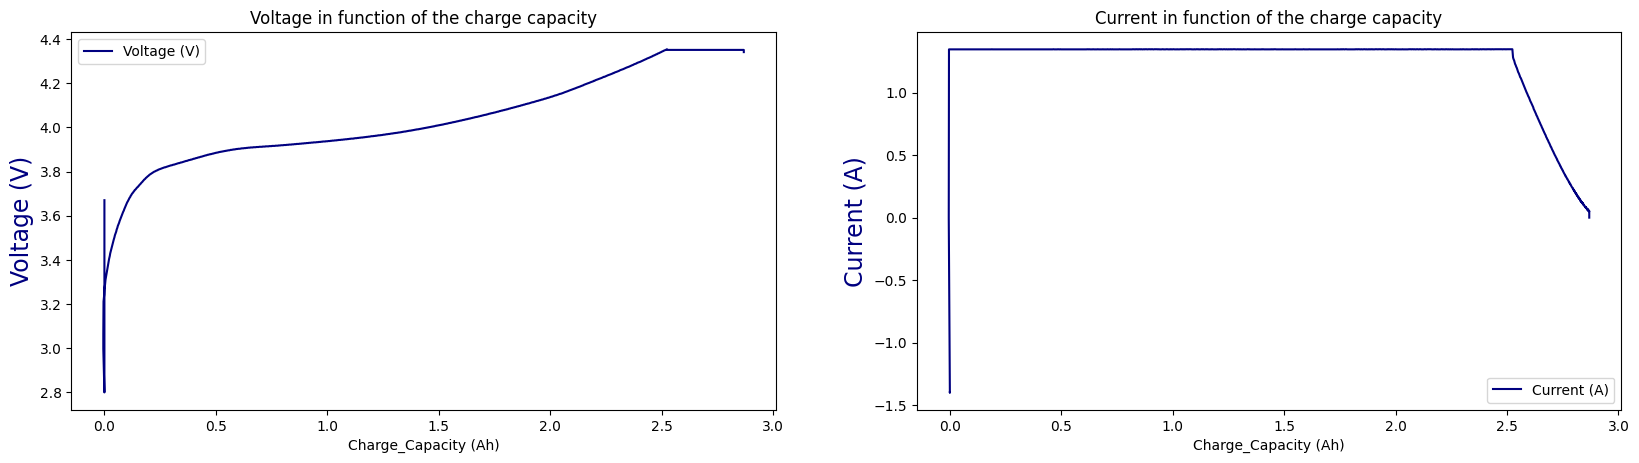

In [177]:
fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# Charge capacity plot
df_gen.plot(x='Charge_Capacity (Ah)',y='Voltage (V)',color='navy',ax=ax[0])
# Charge energy plot
df_gen.plot(x='Charge_Capacity (Ah)',y='Current (A)',color='navy',ax=ax[1])
# Charge energy plot

ax[0].set_title('Voltage in function of the charge capacity',)
ax[1].set_title('Current in function of the charge capacity')
ax[0].set_ylabel('Voltage (V)',color='navy',fontsize=17)
ax[1].set_ylabel('Current (A)', color = 'navy',fontsize=17)
plt.show()

this is the evidence of the non correlation between the current and charge capacity. 
Therefor we can see the relationship between voltage and the charge capacity 

In [178]:
Train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 2 to 1955
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Test_Time (s)            1954 non-null   float64
 1   Cycle_Index              1954 non-null   float64
 2   Current (A)              1954 non-null   float64
 3   Voltage (V)              1954 non-null   float64
 4   Charge_Capacity (Ah)     1954 non-null   float64
 5   Discharge_Capacity (Ah)  1954 non-null   float64
 6   Charge_Energy (Wh)       1954 non-null   float64
 7   Discharge_Energy (Wh)    1954 non-null   float64
dtypes: float64(8)
memory usage: 137.4 KB


In [179]:
Test.shape

(2603, 11)

observation of the cycles on the battery. 

# Note : normalization of the capacity 

In [180]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X)

In [181]:
transformer

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [182]:
RobustScaler(X)

RobustScaler(copy=True, quantile_range=(25.0, 75.0),
             with_centering=array([[0.   ],
       [0.   ],
       [0.   ],
       ...,
       [2.869],
       [2.869],
       [2.869]]),
             with_scaling=True)

# Neural Network model 

## 1/ Recurrent Neural Network 
*LSTM =  Long Short Term Memory* 

In [183]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [196]:
df1 = df[df['Cycle_Index'] < 3 ]

In [184]:
Train.columns

Index(['Date_Time', 'Test_Time (s)', 'Cycle_Index', 'Current (A)',
       'Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)',
       'Charge_Energy (Wh)', 'Discharge_Energy (Wh)',
       'Environment_Temperature (C)', 'Cell_Temperature (C)'],
      dtype='object')

In [185]:
#Train1 = Train_1.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [209]:
train_size = int(len(Train_1) * 0.7)
test_size = len(Train_1) - train_size
train, test = Train_1.iloc[0:train_size], Train_1.iloc[train_size:len(Train_1)]
print(len(train), len(test))

1367 587


In [210]:
from sklearn.preprocessing import RobustScaler

i_columns = ['Voltage (V)', 'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)']

f_transformer = RobustScaler()
cc_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[i_columns].to_numpy())
cc_transformer = cc_transformer.fit(train[['Charge_Capacity (Ah)']])

train.loc[:, i_columns] = f_transformer.transform(train[i_columns].to_numpy())
train['Charge_Capacity (Ah)'] = cc_transformer.transform(train[['Charge_Capacity (Ah)']])

test.loc[:, i_columns] = f_transformer.transform(test[i_columns].to_numpy())
test['Charge_Capacity (Ah)'] = cc_transformer.transform(test[['Charge_Capacity (Ah)']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [211]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [212]:
train1 = train.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [213]:
test1 = test.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [191]:
train.columns

Index(['Date_Time', 'Test_Time (s)', 'Cycle_Index', 'Current (A)',
       'Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)',
       'Charge_Energy (Wh)', 'Discharge_Energy (Wh)',
       'Environment_Temperature (C)', 'Cell_Temperature (C)'],
      dtype='object')

In [214]:
time_steps = 8 #check train.head()

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train1, train1.Charge_Capacity , time_steps)
X_test, y_test = create_dataset(test1, test1.Charge_Capacity , time_steps)

print(X_train.shape, y_train.shape)

(1359, 8, 8) (1359,)


In [215]:
from tensorflow import keras
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [216]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
39/39 [==============================] - 5s 40ms/step - loss: 0.1149 - val_loss: 0.0336
Epoch 2/30
39/39 [==============================] - 1s 16ms/step - loss: 0.6047 - val_loss: 0.4159
Epoch 3/30
39/39 [==============================] - 1s 19ms/step - loss: 0.2938 - val_loss: 0.3404
Epoch 4/30
39/39 [==============================] - 1s 16ms/step - loss: 0.2625 - val_loss: 0.2322
Epoch 5/30
39/39 [==============================] - 1s 17ms/step - loss: 0.1784 - val_loss: 0.0795
Epoch 6/30
39/39 [==============================] - 1s 17ms/step - loss: 0.1767 - val_loss: 0.0419
Epoch 7/30
39/39 [==============================] - 1s 17ms/step - loss: 0.4292 - val_loss: 0.0635
Epoch 8/30
39/39 [==============================] - 1s 16ms/step - loss: 0.4000 - val_loss: 0.0775
Epoch 9/30
39/39 [==============================] - 1s 17ms/step - loss: 0.1465 - val_loss: 0.0990
Epoch 10/30
39/39 [==============================] - 1s 18ms/step - loss: 0.4756 - val_loss: 0.1073
Epoch 11/

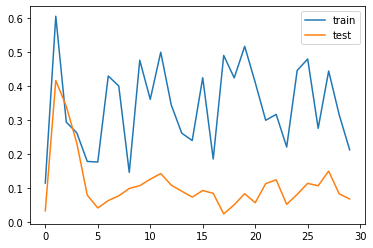

In [217]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [218]:
y_pred = model.predict(X_test)

In [219]:
y_train_inv = cc_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cc_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cc_transformer.inverse_transform(y_pred)

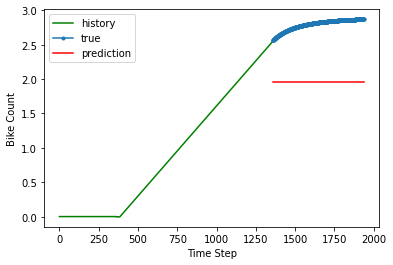

In [220]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

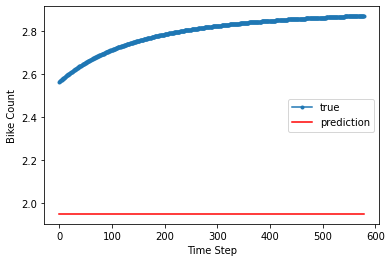

In [221]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();